In [1]:
import bs4 as bs
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
path = 'C:/Users/cfcoo/OneDrive - Ulster University/Ciaran/medium'

In [2]:
def timer(orig_func):
    """
    decorator for logging time of function.
    """
    import time
    
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, *kwargs)
        t2 = time.time() - t1
        print(f"{orig_func.__name__} ran in: {round(t2,3)} seconds")
        return result
    
    return wrapper

In [3]:
source = urllib.request.urlopen('https://www.formula1.com/en/results.html/1990/drivers.html').read()
soup = bs.BeautifulSoup(source,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.drop(["Unnamed: 0","Unnamed: 6"],axis=1, inplace=True)
df.head()

,Pos,Driver,Nationality,Car,PTS
0,1,Ayrton Senna SEN,BRA,McLaren Honda,78
1,2,Alain Prost PRO,FRA,Ferrari,71
2,3,Nelson Piquet PIQ,BRA,Benetton Ford,43
3,3,Gerhard Berger BER,AUT,McLaren Honda,43
4,5,Nigel Mansell MAN,GBR,Ferrari,37


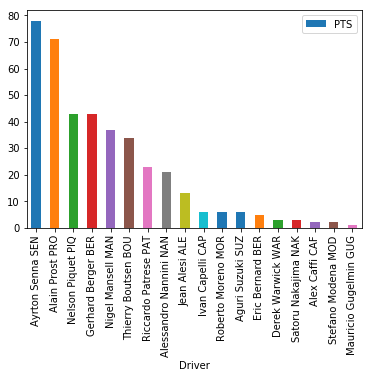

In [4]:
df.plot.bar(x="Driver", y="PTS");

In [5]:
"""
Let's look at a single race result from that season
""" 
source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/1990/races/64/united-states/race-result.html").read()
soup = bs.BeautifulSoup(source,'lxml')

table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.head()

,Unnamed: 0,Pos,No,Driver,Car,Laps,Time/Retired,PTS,Unnamed: 8
0,NaN,1,27,Ayrton Senna SEN,McLaren Honda,72,1:52:32.829,9,NaN
1,NaN,2,4,Jean Alesi ALE,Tyrrell Ford,72,+8.685s,6,NaN
2,NaN,3,5,Thierry Boutsen BOU,Williams Renault,72,+54.080s,4,NaN
3,NaN,4,20,Nelson Piquet PIQ,Benetton Ford,72,+68.358s,3,NaN
4,NaN,5,8,Stefano Modena MOD,Brabham Judd,72,+69.503s,2,NaN


In [6]:
HOMEPAGE = 'https://www.formula1.com/'
YEAR = '1990'

In [7]:
@timer
def get_race_urls(year):
    race_urls = []
    source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/{YEAR}/races.html").read()
    soup = bs.BeautifulSoup(source,'lxml')
    
    for url in soup.find_all('a'):
        if YEAR in str(url.get('href')) and 'race-result' in str(url.get('href')) and url.get('href') not in race_urls:
            race_urls.append(url.get('href'))
    return race_urls

In [8]:
race_urls = get_race_urls(YEAR)
season_results_df = None

@timer
def seasons_results(race_urls):

    for n, race in enumerate(race_urls):

        placeholder = [0 for i in range(n)]
        race_name = race.split('/')[6]

        results_page = urllib.request.urlopen(f"{HOMEPAGE}{race}").read()
        race_results = bs.BeautifulSoup(results_page,'lxml')

        table = race_results.find_all('table')[0] 
        df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
        df.drop(["Unnamed: 0","Unnamed: 8"], axis=1, inplace=True)
        df.set_index('No', inplace=True)

        #establish season results df on first race information
        if n == 0:
            season_results_df = pd.DataFrame(df[['Driver','Car']], columns=['Driver','Car'], index=df.index)
       
        #add drivers if they are not in season_results_df
        for ind in df.index.difference(season_results_df.index):
            season_results_df.loc[ind] = [df['Driver'].loc[ind],df['Car'].loc[ind],*placeholder]

        for ind in df.index:
            pts = df['PTS'].where(df.index == ind).dropna().values[0]
#             if pts == 9:
#                 pts = 10 #if mapping differnt points systems
            season_results_df.loc[ind, race_name] = int(pts)
    
    #####Format the dataframe with a few lines#####
    season_results_df.sort_index(inplace=True)
    season_results_df.fillna(0, inplace=True)   
    season_results_df['Car'] = season_results_df['Car'].apply(lambda s : s[:3]).map(str.upper) #retain last 3 digits and caps
    return season_results_df 

get_race_urls ran in: 3.748 seconds


In [ ]:
season_results_df = seasons_results(race_urls)
season_results_df

In [10]:
"""
cumulatively add the drivers' points after each race
"""
cum_results = season_results_df.drop(['Driver', 'Car'], axis=1).cumsum(axis=1)

In [11]:
####configure dataframe for plotting####
cum_results['Driver'] = season_results_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
cum_results.sort_values(by='australia',ascending=False, inplace=True)
cum_results.set_index('Driver', inplace=True)
cum_results

,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Driver,,,,,,,,,,,,,,,,
SEN,9.0,13.0,13.0,22.0,31.0,31.0,35.0,39.0,48.0,54.0,63.0,72.0,78.0,78.0,78.0,78.0
PRO,0.0,9.0,12.0,12.0,14.0,23.0,32.0,41.0,44.0,44.0,50.0,56.0,60.0,69.0,69.0,73.0
PIQ,3.0,4.0,6.0,6.0,12.0,13.0,16.0,18.0,18.0,22.0,24.0,24.0,26.0,26.0,35.0,44.0
BER,0.0,6.0,12.0,16.0,19.0,23.0,25.0,25.0,29.0,29.0,33.0,37.0,40.0,40.0,40.0,43.0
MAN,0.0,3.0,3.0,3.0,7.0,13.0,13.0,13.0,13.0,13.0,13.0,16.0,25.0,31.0,31.0,37.0
BOU,4.0,6.0,6.0,9.0,9.0,11.0,11.0,17.0,18.0,27.0,27.0,27.0,27.0,30.0,32.0,34.0
NAN,0.0,0.0,4.0,4.0,4.0,7.0,7.0,7.0,13.0,13.0,16.0,16.0,17.0,21.0,27.0,27.0
PAT,0.0,0.0,9.0,9.0,9.0,9.0,10.0,10.0,12.0,15.0,15.0,17.0,17.0,19.0,22.0,23.0
ALE,6.0,6.0,7.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0


Text(0,0.5,'Points')

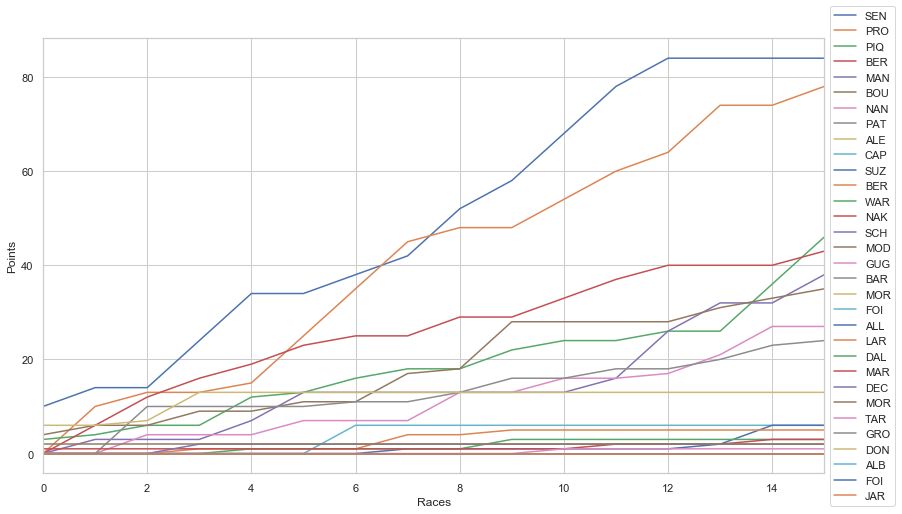

In [16]:
fig = plt.figure(figsize=(14,8))
#ax = fig.add_subplot(1, 1, 1) 
sns.set(style='whitegrid')

cum_results.transpose().plot.line(figsize=(14,8),use_index=False, xlim=(0,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")
#plt.savefig(f"{path}/cum1990.png", dpi=300)

In [172]:
def best_11_cumsum(season_results_df):
    """
    compute cumulative scores based on best 11 results
    """

    series = season_results_df.drop(['Driver', 'Car'])#.drop(['Driver', 'Car'], axis=1).iloc[0]
    best_11_cum = np.array(series[:11].cumsum())
    best_11_S = series[:11].sort_values()
    best_11 = np.array(series[:11].sort_values())
    
    for pts in series[11:]:
        if pts > best_11_S.any():
            best_11 = np.delete(best_11,0)
            best_11 = np.insert(best_11, -1, pts)
            
            best_11_cum = np.insert(best_11_cum, len(best_11_cum), np.array(best_11).cumsum()[-1])
            
        else:
            best_11_cum = np.insert(best_11_cum, len(best_11_cum), best_11_cum[-1])
            
    return best_11_cum

In [176]:
best_11_df = season_results_df.apply(best_11_cumsum, axis=1)
best_11_df = pd.DataFrame(pd.DataFrame(best_11_df)[0].tolist(), columns=season_results_df.columns[2:])
best_11_df['Driver'] = season_results_df['Driver'].values
best_11_df['Driver'] = best_11_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
cols_new = list(best_11_df.columns[-1:]) + list(best_11_df.columns[:-1])
best_11_df = best_11_df[cols_new]
best_11_df.sort_values(by='australia',ascending=False, inplace=True)
best_11_df.set_index('Driver', inplace=True)

best_11_df.head()

,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Driver,,,,,,,,,,,,,,,,
SEN,9.0,13.0,13.0,22.0,31.0,31.0,35.0,39.0,48.0,54.0,63.0,72.0,78.0,78.0,78.0,78.0
PRO,0.0,9.0,12.0,12.0,14.0,23.0,32.0,41.0,44.0,44.0,50.0,56.0,60.0,69.0,69.0,71.0
PIQ,3.0,4.0,6.0,6.0,12.0,13.0,16.0,18.0,18.0,22.0,24.0,24.0,26.0,26.0,35.0,43.0
BER,0.0,6.0,12.0,16.0,19.0,23.0,25.0,25.0,29.0,29.0,33.0,37.0,40.0,40.0,40.0,43.0
BOU,4.0,6.0,6.0,9.0,9.0,11.0,11.0,17.0,18.0,27.0,27.0,27.0,27.0,30.0,32.0,34.0


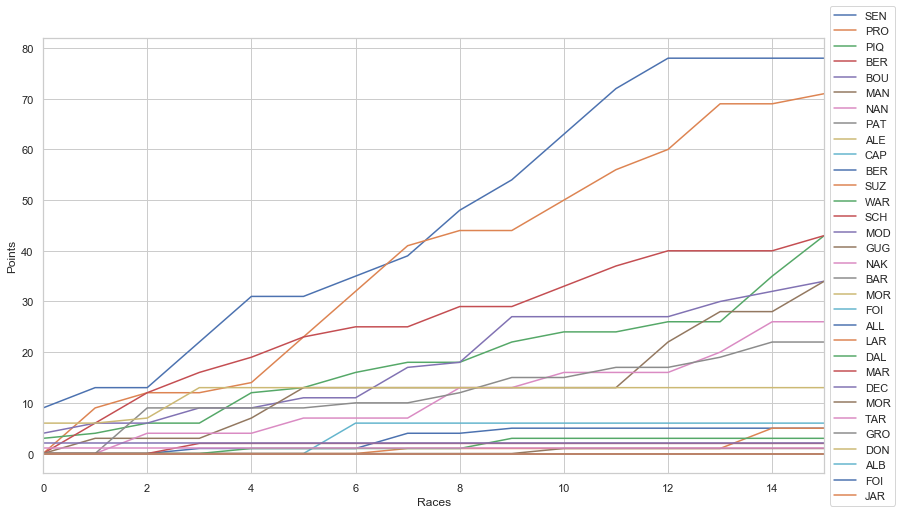

In [177]:
fig = plt.figure(figsize=(14,8))
#ax = fig.add_subplot(1, 1, 1) 
sns.set(style='whitegrid')

best_11_df.transpose().plot.line(figsize=(14,8),use_index=False, xlim=(0,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")
plt.savefig(f"{path}/best_11_cum1990.png", dpi=300)

In [17]:
season_results_df['Driver'] = season_results_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
season_results_df.sort_values(by='belgium',ascending=False, inplace=True)
season_results_df.set_index('Driver', inplace=True)
season_results_df.drop('Car', axis=1,  inplace=True)

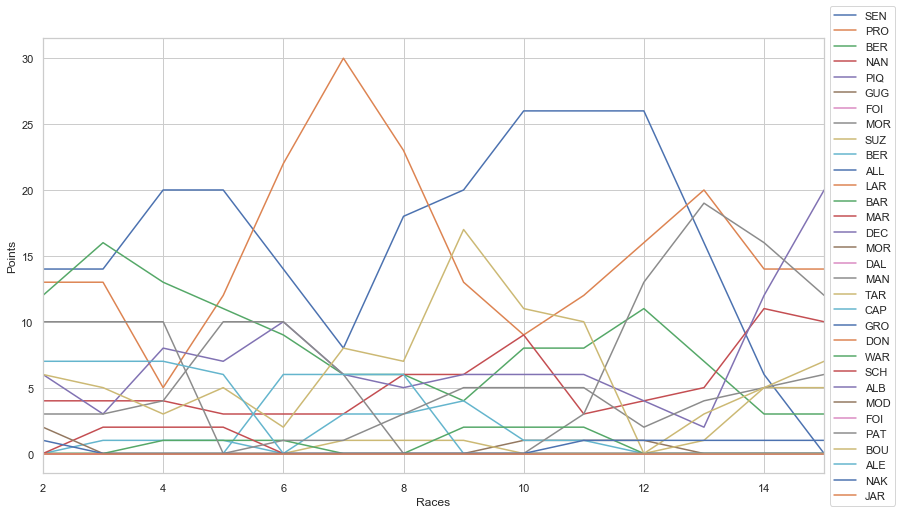

In [18]:
fig = plt.figure(figsize=(14,8))
sns.set(style='whitegrid')

ax = season_results_df.transpose().rolling(3).sum().plot(figsize=(14,8),use_index=False, xlim=(2,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")

plt.savefig(f"{path}/roll1990.png", dpi=300)